## Data augmentation
#### Author: Pinglei He, Kaiao Wen, Albache Jean, Augusto Oliveira, Yassine Oudghiri

## Creation of dedicated functions

Module importation

In [2]:
# python modules
import random

from PIL import Image, ImageChops, ImageOps
import numpy as np
import random as rd
import os
from math import ceil

Constants

In [3]:
pixel_max = 65535  # 32 bit unsigned integers
base_path = "data/dataset/base_png"
im_size = 512  # 512 * 512 pixels per base

## Pipeline Creation
The following function combines multiple processing operations into one

In [4]:
def create_pipeline(*operations):
    """Select base image using selector function, and return the image after all transformations functions"""
    def pipeline(img: Image.Image):
        for op in operations:
            img = op(img)
        return img
    return pipeline

Function for selection of base image

In [5]:
def select() -> Image.Image:
    """Selects a random base image."""
    base_files = os.listdir(base_path)
    selected = rd.choice(base_files)
    return Image.open(os.path.join(base_path, selected))

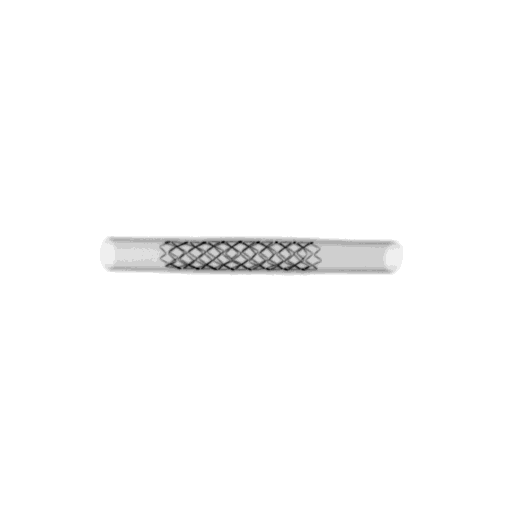

In [6]:
# example
test_img = select()
test_img

In [7]:
def rotate(img: Image.Image, angle=None) -> Image.Image:
    if angle is None:
        angle = rd.uniform(0, 360)
    return img.rotate(angle, fillcolor=pixel_max)

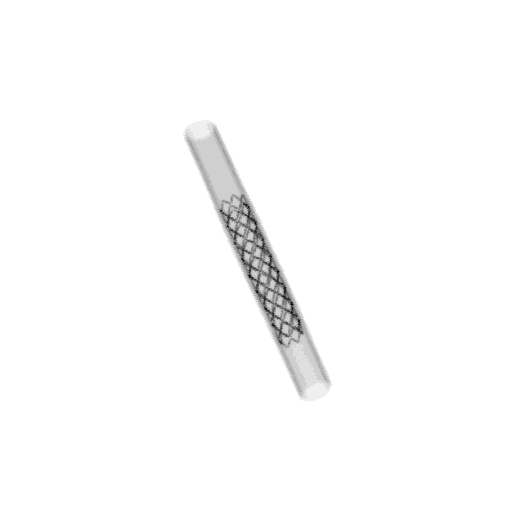

In [8]:
# example
test_img_rotated = rotate(test_img)
test_img_rotated

In [9]:
def rescale(img: Image.Image, scale=None) -> Image.Image:
    if not scale:
        scale = rd.uniform(0.2, 1.6)
    # shrink the image
    thumbnail_size = ceil(im_size * scale / 2) * 2

    # add border to have the original image dimensions if image is shrunken
    if thumbnail_size <= im_size:
        img.thumbnail((thumbnail_size, thumbnail_size))
        border_size = (im_size - thumbnail_size) // 2
        return ImageOps.expand(img, border=border_size, fill=pixel_max)

    # crop image if image is enlarged
    border_size = (thumbnail_size - im_size) // 2
    img = img.resize((thumbnail_size, thumbnail_size))
    return img.crop((border_size, border_size, border_size + im_size, border_size + im_size))

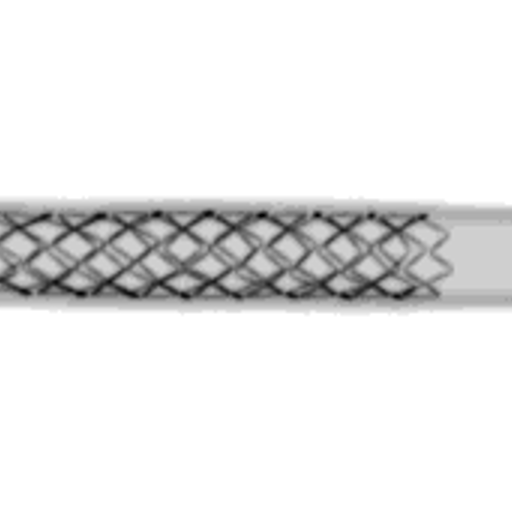

In [10]:
from copy import deepcopy
# example
test_img_rescaled = rescale(deepcopy(test_img), scale=3) # scale set to 3 only for visualization purposes
test_img_rescaled

In [11]:
def translate(img: Image.Image, tx=None, ty=None) -> Image.Image:
    """
    :param img: image file
    :param tx: the number of pixels the image is translated to the left
    :param ty: the number of pixels the image is translated to the right
    :return: the translated image
    """
    # if tx or ty set to none, randomly shift by -200 to 200 pixels in both directions
    if not tx:
        tx = rd.randint(-200, 200)
    if not ty:
        ty = rd.randint(-200, 200)
    return ImageChops.offset(img, tx, ty)

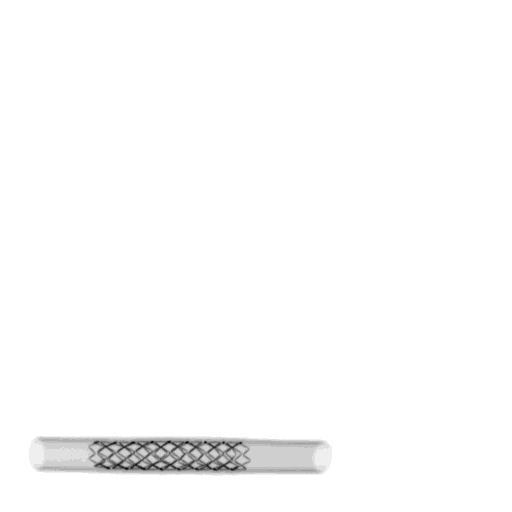

In [12]:
test_img_shifted = translate(test_img)
test_img_shifted

In [13]:
def flip_and_mirror(img: Image.Image) -> Image.Image:
    if np.random.uniform() >= 0.5: # flip with a probability of 0.5
        img = ImageOps.flip(img)
    if np.random.uniform() >= 0.5: # mirror with a probability of 0.5
        img = ImageOps.mirror(img)
    return img

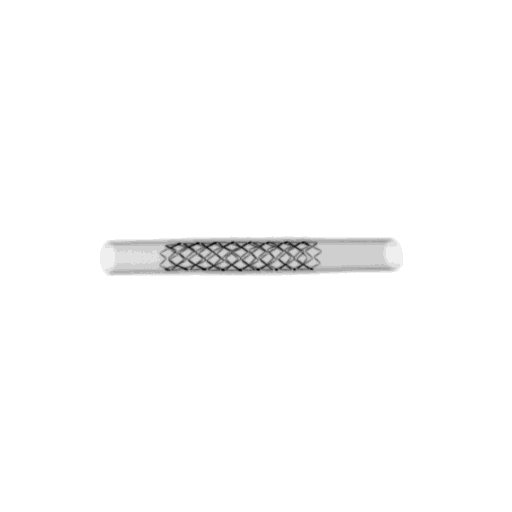

In [14]:
test_img_flipped_and_mirrored = flip_and_mirror(test_img)
test_img_flipped_and_mirrored

pipeline creation

In [15]:
pipeline = create_pipeline(flip_and_mirror, rotate, rescale, translate)

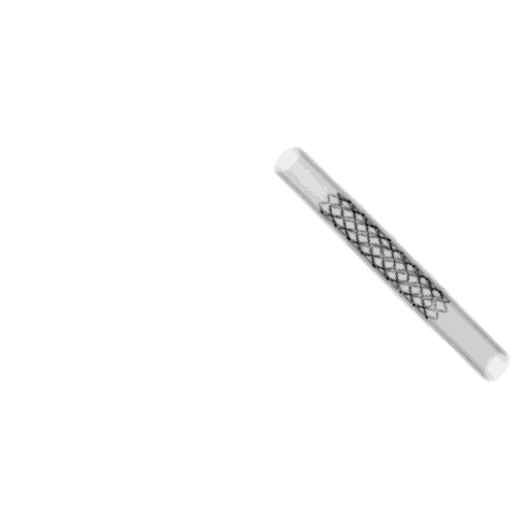

In [16]:
# test example
test_img_processed = pipeline(test_img)
test_img_processed

## Database creation

In [19]:
import uuid # for random image id generation

In [26]:
save_path_train = "data/dataset/train"
save_path_test = "data/dataset/test"

def generate_training_image(number: int, train_test_split: float):
    """Randomly generate a certain number of training images without noise"""
    if train_test_split< 0 or train_test_split >= 1:
        raise Exception("The split percentage should be a float between 0 and 1!")
    if os.path.isdir(save_path_train): return # return if training image folder already exists
    os.makedirs(os.path.join(save_path_train, "y"))
    if train_test_split < 1:
        os.makedirs(os.path.join(save_path_test, "y"))

    generated_test_size = ceil(number * (1 - train_test_split))
    generated_train_size = number - generated_test_size
    for iter in range(number):
        image_id = str(uuid.uuid4())
        img = select()
        img_processed = pipeline(img)
        save_path = save_path_test if iter < generated_test_size else save_path_train
        img_processed.save(os.path.join(save_path, f"{image_id}.png"))
    print("Denoised image data augmentation finished.")
    print(f"In total {number} images are generated, {generated_test_size} in test set and {generated_train_size} in training set.")

In [27]:
# number of images without noise
train_size = 20

In [29]:
generate_training_image(train_size, train_test_split=0.8)

Denoised image data augmentation finished.
In total 20 images are generated, 4 in test set and 16 in training set.
